In [1]:
include("OQS_Tools_v1.jl")
using LinearAlgebra, Plots, PolyChaos
using .OQS_Tools_v1

function evolve_corrs(C0, H, dt, tmax, N)
    n = 2N + 1
    Cs = Vector{Array{ComplexF64}}(undef, 0)
    times = collect(0:dt:tmax)
    C0 = Matrix(C0)
    H = Matrix(H)

    for t in times
        U = exp(-im * t * H)
        C = U * C0 * U'
        push!(Cs, C)
    end

    return Cs
end


evolve_corrs (generic function with 1 method)

In [31]:
N = 100
dt = 0.1
tmax = 100.0
Esys = 0.0
sys = N+1

D = 1.0
g = 0.5
beta = 100.0
mu = 0.0
sys_occ = 1.0

J = create_spectral("elliptical", D, g)
J1, J2 = thermofield_transform(J, beta, mu)

E1, h1 = chain_map(J1, N, D)
E2, h2 = chain_map(J2, N, D)
h = [reverse(h1); h2]

H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
C0 = prepare_correlations(N,sys,sys_occ)
Cs = evolve_corrs(C0, H, dt, tmax, N)


1001-element Vector{Array{ComplexF64}}:
 [1.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000002 + 0.0im 4.336808689942018e-19 + 6.938893903907228e-18im … 0.0 + 0.0im 0.0 + 0.0im; 4.336808689942018e-19 - 6.938893903907228e-18im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0 + 0.0im -1.734723475976807e-18 + 2.7755575615628914e-17im … 0.0 + 0.0im 0.0 + 0.0im; -1.734723475976807e-18 - 2.7755575615628914e-17im 1.0000000000000002 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [1.0000000000000004 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 1.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; 0.0 + 0.0im 0.0 + 0.0im … 0.0

# occupation

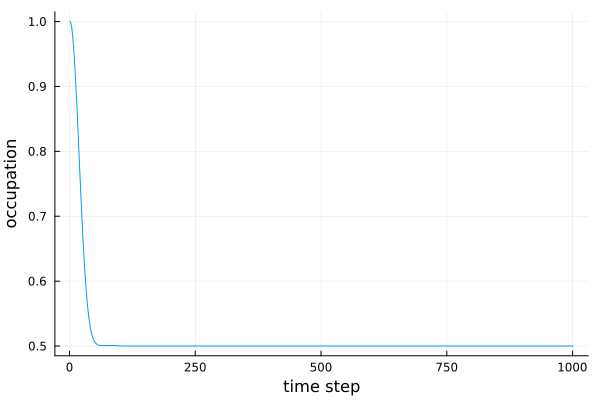

In [32]:
nsys = [real(C[sys,sys]) for C in Cs]
p = plot(nsys, xlabel="time step", ylabel="occupation",label="")
display(p)

# flux

In [33]:
anim = @animate for (t,C) in enumerate(Cs)
    flux = imag.(diag(C, 1)) .* 2 .* h
    occ = real.(diag(C, 0))
    p1 = plot(-N+0.5:1:N-0.5, flux, title="Time = $(round(dt*(t-1),digits=1))", 
        xlabel="inter-site",ylabel="flux", ylims=(0.0,0.3))
    p2 = plot(-N+0.5:1:N-0.5, flux, title="Time = $(round(dt*(t-1),digits=1))", 
        xlabel="inter-site",ylabel="flux", ylims=(0.0,0.3))
    end
gif(anim, "C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\figures\\flux_g$(g)B$(beta)mu$(mu).mp4", fps=20)


┌ Info: Saved animation to C:\Users\ben_b\Documents\Git Repos\AgeingManyBodyQuantumSys\figures\flux_g0.5B100.0mu0.0.mp4
└ @ Plots C:\Users\ben_b\.julia\packages\Plots\8ZnR3\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\figures\\flux_g0.5B100.0mu0.0.mp4")

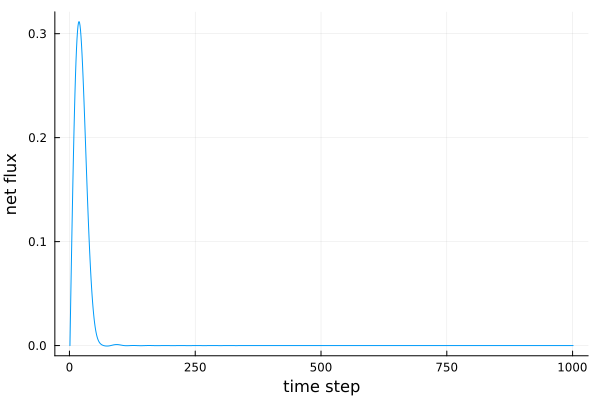

In [34]:
net_flux = [imag(C[sys, sys+1] - C[sys-1,sys]) for C in Cs]
p = plot(net_flux, xlabel="time step", ylabel="net flux",label="")
display(p)



# Chain coefficients

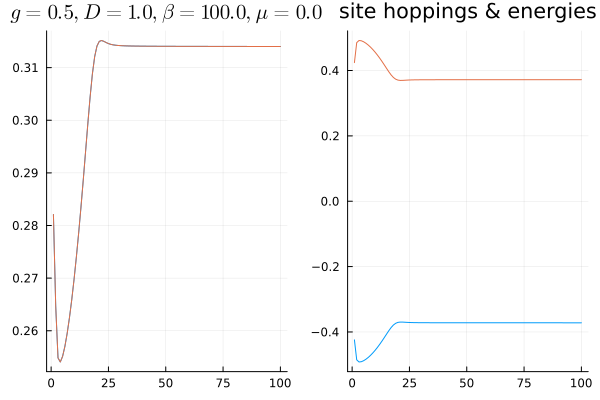

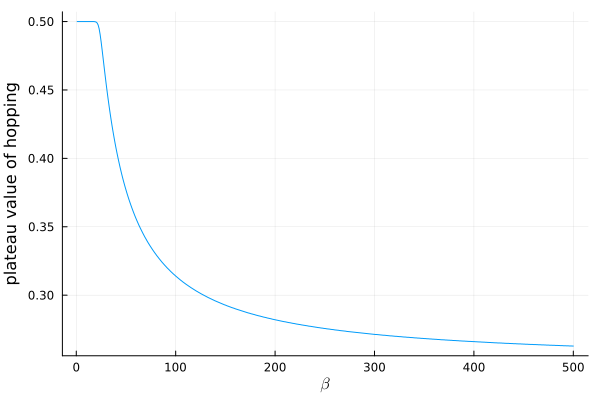

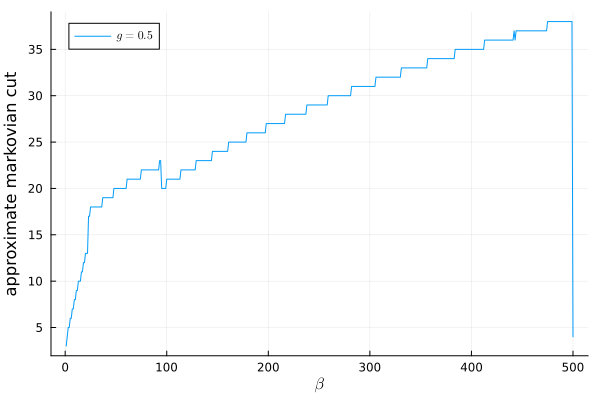

In [35]:
p1 = plot(h1, title="\$ g=$g, D=$D, \\beta=$beta, \\mu=$mu \$",label="")
plot!(p1, h2,label="")
p2 = plot(E1, title="site hoppings & energies",label="")
plot!(p2, E2,label="")
display(plot(p1,p2))

hf = zeros(500)
cutoff = zeros(500)
J = create_spectral("elliptical", D, g)
for (i, beta) in enumerate(1.0:1.0:500.0)
    Jt = thermofield_transform(J, beta, 0.0)[1]
    ht = chain_map(Jt, N, D)[2]
    hf[i] = ht[end]
    idx = findfirst(k -> maximum(ht[k:k+10]) - minimum(ht[k:k+10]) < 0.001 , collect(1:length(ht)-10))
    cutoff[i] = idx
end

display(plot(hf, xlabel="\$ \\beta \$", ylabel="plateau value of hopping",label=""))
display(plot(cutoff, xlabel="\$ \\beta \$", ylabel="approximate markovian cut",label="\$ g = $g \$"))




# measures

In [36]:
function trace_distance(A, B, n, N) #1st matrix, 2nd matrix, chain sites included, chain sites
    Ma = A[N+1-n:N+1+n,N+1-n:N+1+n]
    Mb = B[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = I(2n+1)
    d2 = sqrt(0.5 * (det(Id - 2*Ma + 2*Ma*Ma) + det(Id - 2*Mb + 2*Mb*Mb) - 2*det(Id - Ma - Mb + 2*Ma*Mb)))
    return d2 #each term in D is the 'overlap' of the two correlation matrices
end

function block_entropy(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Id = Matrix(1.0I, 2n+1, 2n+1)
    evals1 = eigvals(Csub)
    evals2 = eigvals(Id .- Csub)
    S = -sum(evals1 .* log.(evals1) .+ evals2 .* log.(evals2))
    return S
end

function VNentropy(C, n, N)
    Id = Matrix(1.0I, size(C))
    evals1 = eigvals(C)
    evals2 = eigvals(Id .- C)
    S = -sum(evals1 .* log.(evals1) .+ evals2 .* log.(evals2))
    return S
end

function mutual_info(C, n, N)
    Csub = C[N+1-n:N+1+n,N+1-n:N+1+n]
    Cfull = C[N+1-n:N+1, N+1-n:N+1]
    Cempty = C[N+1:N+1+n, N+1:N+1+n]
    return VNentropy(Cfull,n,N) + VNentropy(Cempty,n,N) - VNentropy(Csub,n,N)
end


mutual_info (generic function with 1 method)

In [ ]:
C0_full = prepare_correlations(N,sys,1.0)
C0_empty = prepare_correlations(N,sys,0.0)

Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
len = length(Cs_full)

anim = @animate for n in 0:50
    D = [trace_distance(Cs_full[t], Cs_empty[t], n, N) for t in 1:len]
    Df = D[2:end]
    Di = D[1:end-1]
    dD_dt = (Df - Di)/dt
    p1 = plot(real.(D),xlabel="timestep",ylabel="trace distance",title="n=$n")
    p2 = plot(real.(dD_dt),xlabel="timestep",ylabel="\$ \\frac{d}{dt}\$ trace distance",title="n=$n", yrange=(-0.3,0.1))
    p = plot(p1,p2)
end

gif(anim, "C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\figures\\traceDist_g$(g)B$(beta)mu$(mu).mp4", fps=5)


[out#0/mp4 @ 00000204ef8fdd00] Error opening output \Users\ben\AgeingManyBodyQuantumSys\figures\traceDist_g0.5B1.0mu0.0.mp4: No such file or directory
Error opening output file \Users\ben\AgeingManyBodyQuantumSys\figures\traceDist_g0.5B1.0mu0.0.mp4.
Error opening output files: No such file or directory


ProcessFailedException: failed process: Process(setenv(`'C:\Users\ben_b\.julia\artifacts\8f71eb37d5b304026b6363d835f8c65ff1920339\bin\ffmpeg.exe' -v 16 -framerate 5 -i 'C:\Users\ben_b\AppData\Local\Temp\jl_u28GKu/%06d.png' -i 'C:\Users\ben_b\AppData\Local\Temp\jl_u28GKu/palette.bmp' -lavfi paletteuse=dither=sierra2_4a -loop 0 -y '\Users\ben\AgeingManyBodyQuantumSys\figures\traceDist_g0.5B1.0mu0.0.mp4'`,["WINDIR=C:\\WINDOWS", "PATH=C:\\Users\\ben_b\\.julia\\artifacts\\3af036b12a076c2d4c042dde6d956ef4eac2c2ce\\bin;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\13e3cf8e6f38d3b6418b758bb68cb8b149c28251\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\ce4261864aeaa78b205a3f6fb750be4c4afe9b4b\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\1da3b3a2698813adf2b925c46aa2d68ec8474449\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\58a307887a7b823f6a7cac7e6337710ec14aced2\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\df4cc9189a878ad66ad99fed70ece5cf4e45b246\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\90274e5aad7e8e2a9105fae1f4b4fc52a955322f\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\fcc05863e77d0e700007d714ef7304c87b39d10e\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\166f431d14e588224598f7952888bb847a545ac6\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\51e4c0b5a201939ab2352553b85f5d0932d5cf03\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\cb74fa09f359d430ea01be69a61cd98b50ec8c22\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\6e310796647a1c58e5873a7ab7ad32b8e60dea3f\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\d119ba6f3cc7e3fb09a8bb637f705bf9d9982000\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\ec3406e9ba84281719f20b0fb3a874c9e3bac027\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\8d9f87bf9e08a0e0db47c0ab531ee29fff143eee\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\41cbcbec1d1b6ca0484999b1db571f8066f29233\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\5c7df64500371e5ab4723fe2fc999b996aa8f3a7\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\81ad3b6f8af8fa057c1a9640ca91454b669b342b\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\8258f1ad1bf2f9853eb157e9d4b755f0e427a0ea\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\25bfd4c7adfcd3cb3399a7c509ec239a32c247f3\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\9fa0dc316d94c97a5ce05d7eba953db78ea33810\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\98941fbb5eed27cef1d77fa8710290bc197dd24f\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\ba2dc75245508e0cf0c860081b2f2fd10bdf4357\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\adfa85d12aa4ae2bccc47a2af00bdcc97f4ff47c\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\7e207f56275705f9cbc88b826acd28ea0e40f1ae\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\8f71eb37d5b304026b6363d835f8c65ff1920339\\bin;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin\\..\\lib\\julia;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin\\..\\lib;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin;C:\\WINDOWS\\system32;C:\\WINDOWS;C:\\WINDOWS\\System32\\Wbem;C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0\\;C:\\WINDOWS\\System32\\OpenSSH\\;C:\\Program Files\\NVIDIA Corporation\\Nsight Compute 2025.3.1\\;C:\\Program Files\\NVIDIA Corporation\\NVIDIA App\\NvDLISR;C:\\Program Files (x86)\\NVIDIA Corporation\\PhysX\\Common;C:\\Program Files\\Git\\cmd;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python311\\;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python314\\Scripts\\;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python314\\;C:\\Users\\ben_b\\AppData\\Local\\Microsoft\\WindowsApps;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Microsoft VS Code\\bin", "ELECTRON_RUN_AS_NODE=1", "USERDOMAIN_ROAMINGPROFILE=RIGID_STALLION", "VSCODE_CODE_CACHE_PATH=C:\\Users\\ben_b\\AppData\\Roaming\\Code\\CachedData\\c9d77990917f3102ada88be140d28b038d1dd7c7", "LOCALAPPDATA=C:\\Users\\ben_b\\AppData\\Local", "GKSWSTYPE=svg", "HOMEPATH=\\Users\\ben_b", "VSCODE_NLS_CONFIG={\"userLocale\":\"en-us\",\"osLocale\":\"en-us\",\"resolvedLanguage\":\"en\",\"defaultMessagesFile\":\"C:\\\\Users\\\\ben_b\\\\AppData\\\\Local\\\\Programs\\\\Microsoft VS Code\\\\resources\\\\app\\\\out\\\\nls.messages.json\",\"locale\":\"en-us\",\"availableLanguages\":{}}", "PROCESSOR_IDENTIFIER=AMD64 Family 25 Model 97 Stepping 2, AuthenticAMD", "GKS_ENCODING=utf8", "EFC_162860_1592913036=1", "NUMBER_OF_PROCESSORS=24", "VSCODE_PID=193596", "PATHEXT=.COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC", "SESSIONNAME=Console", "VSCODE_IPC_HOOK=\\\\.\\pipe\\3dcb9cca-1.108.2-main-sock", "GKS_USE_CAIRO_PNG=true", "APPDATA=C:\\Users\\ben_b\\AppData\\Roaming", "PSMODULEPATH=C:\\Program Files\\WindowsPowerShell\\Modules;C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\Modules", "SYSTEMROOT=C:\\WINDOWS", "COMMONPROGRAMW6432=C:\\Program Files\\Common Files", "PROGRAMDATA=C:\\ProgramData", "PUBLIC=C:\\Users\\Public", "USERDOMAIN=RIGID_STALLION", "OS=Windows_NT", "PROCESSOR_REVISION=6102", "TMP=C:\\Users\\ben_b\\AppData\\Local\\Temp", "EFC_162860_2775293581=1", "FONTCONFIG_FILE=C:\\Users\\ben_b\\.julia\\artifacts\\cb74fa09f359d430ea01be69a61cd98b50ec8c22\\etc\\fonts\\fonts.conf", "ONEDRIVECOMMERCIAL=C:\\Users\\ben_b\\OneDrive - University of Bristol", "VSCODE_ESM_ENTRYPOINT=vs/workbench/api/node/extensionHostProcess", "COMMONPROGRAMFILES(X86)=C:\\Program Files (x86)\\Common Files", "COMSPEC=C:\\WINDOWS\\system32\\cmd.exe", "OPENBLAS_DEFAULT_NUM_THREADS=1", "GKS_FILEPATH=C:\\Users\\ben_b\\AppData\\Local\\Temp\\jl_mpE9mNaF2N.svg", "ALLUSERSPROFILE=C:\\ProgramData", "VSCODE_CRASH_REPORTER_PROCESS_TYPE=extensionHost", "COMMONPROGRAMFILES=C:\\Program Files\\Common Files", "COMPUTERNAME=RIGID_STALLION", "JULIA_NUM_THREADS=8", "ONEDRIVE=C:\\Users\\ben_b\\OneDrive - University of Bristol", "VSCODE_CWD=C:\\Users\\ben_b\\AppData\\Local\\Programs\\Microsoft VS Code", "VSCODE_HANDLES_UNCAUGHT_ERRORS=true", "EFC_162860_1262719628=1", "GRDIR=C:\\Users\\ben_b\\.julia\\artifacts\\a54b856f4d0dfe6301d42d55eba59ee6c86756c2", "USERNAME=ben_b", "PROGRAMFILES(X86)=C:\\Program Files (x86)", "PROGRAMFILES=C:\\Program Files", "GKS_FONTPATH=C:\\Users\\ben_b\\.julia\\artifacts\\a54b856f4d0dfe6301d42d55eba59ee6c86756c2", "CHROME_CRASHPAD_PIPE_NAME=\\\\.\\pipe\\crashpad_193596_XSBKMKMIOSUHQFDV", "LOGONSERVER=\\\\RIGID_STALLION", "ONEDRIVECONSUMER=C:\\Users\\ben_b\\OneDrive", "USERPROFILE=C:\\Users\\ben_b", "DRIVERDATA=C:\\Windows\\System32\\Drivers\\DriverData", "FONTCONFIG_PATH=C:\\Users\\ben_b\\.julia\\artifacts\\cb74fa09f359d430ea01be69a61cd98b50ec8c22\\etc\\fonts", "EFC_162860_3789132940=1", "FPS_BROWSER_USER_PROFILE_STRING=Default", "AMDRMSDKPATH=C:\\Program Files\\AMD\\RyzenMasterSDK\\", "PROCESSOR_LEVEL=25", "SYSTEMDRIVE=C:", "EFC_162860_2283032206=1", "FPS_BROWSER_APP_PROFILE_STRING=Internet Explorer", "PROGRAMW6432=C:\\Program Files", "TEMP=C:\\Users\\ben_b\\AppData\\Local\\Temp", "HOMEDRIVE=C:", "OPENBLAS_MAIN_FREE=1", "PROCESSOR_ARCHITECTURE=AMD64"]), ProcessExited(4294967294)) [4294967294]


In [ ]:
anim = @animate for n in 0:30
    S = [block_entropy(Cs_empty[t], n, N) for t in 1:len]
    S_f = S[2:end]
    S_i = S[1:end-1]
    sigma = (S_f - S_i)/dt
    println("n=$n")
    p = plot(real.(sigma),xlabel="timestep",ylabel="entropy production",title="n=$n",yrange=(-0.2,0.5))
end

gif(anim, "C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\figures\\entropy_g$(g)B$(beta)mu$(mu).mp4", fps=1)


n=0
n=1
n=2
n=3
n=4
n=5
n=6
n=7
n=8
n=9
n=10
n=11
n=12
n=13
n=14
n=15
n=16
n=17
n=18
n=19
n=20
n=21
n=22
n=23
n=24
n=25
n=26
n=27
n=28
n=29
n=30


[out#0/mp4 @ 0000022b6cfbd480] Error opening output \Users\ben\AgeingManyBodyQuantumSys\figures\entropy_g0.5B1.0mu0.0.mp4: No such file or directory
Error opening output file \Users\ben\AgeingManyBodyQuantumSys\figures\entropy_g0.5B1.0mu0.0.mp4.
Error opening output files: No such file or directory


ProcessFailedException: failed process: Process(setenv(`'C:\Users\ben_b\.julia\artifacts\8f71eb37d5b304026b6363d835f8c65ff1920339\bin\ffmpeg.exe' -v 16 -framerate 1 -i 'C:\Users\ben_b\AppData\Local\Temp\jl_ht9Sfz/%06d.png' -i 'C:\Users\ben_b\AppData\Local\Temp\jl_ht9Sfz/palette.bmp' -lavfi paletteuse=dither=sierra2_4a -loop 0 -y '\Users\ben\AgeingManyBodyQuantumSys\figures\entropy_g0.5B1.0mu0.0.mp4'`,["WINDIR=C:\\WINDOWS", "PATH=C:\\Users\\ben_b\\.julia\\artifacts\\3af036b12a076c2d4c042dde6d956ef4eac2c2ce\\bin;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\13e3cf8e6f38d3b6418b758bb68cb8b149c28251\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\ce4261864aeaa78b205a3f6fb750be4c4afe9b4b\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\1da3b3a2698813adf2b925c46aa2d68ec8474449\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\58a307887a7b823f6a7cac7e6337710ec14aced2\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\df4cc9189a878ad66ad99fed70ece5cf4e45b246\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\90274e5aad7e8e2a9105fae1f4b4fc52a955322f\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\fcc05863e77d0e700007d714ef7304c87b39d10e\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\166f431d14e588224598f7952888bb847a545ac6\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\51e4c0b5a201939ab2352553b85f5d0932d5cf03\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\cb74fa09f359d430ea01be69a61cd98b50ec8c22\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\6e310796647a1c58e5873a7ab7ad32b8e60dea3f\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\d119ba6f3cc7e3fb09a8bb637f705bf9d9982000\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\ec3406e9ba84281719f20b0fb3a874c9e3bac027\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\8d9f87bf9e08a0e0db47c0ab531ee29fff143eee\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\41cbcbec1d1b6ca0484999b1db571f8066f29233\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\5c7df64500371e5ab4723fe2fc999b996aa8f3a7\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\81ad3b6f8af8fa057c1a9640ca91454b669b342b\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\8258f1ad1bf2f9853eb157e9d4b755f0e427a0ea\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\25bfd4c7adfcd3cb3399a7c509ec239a32c247f3\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\9fa0dc316d94c97a5ce05d7eba953db78ea33810\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\98941fbb5eed27cef1d77fa8710290bc197dd24f\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\ba2dc75245508e0cf0c860081b2f2fd10bdf4357\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\adfa85d12aa4ae2bccc47a2af00bdcc97f4ff47c\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\7e207f56275705f9cbc88b826acd28ea0e40f1ae\\bin;C:\\Users\\ben_b\\.julia\\artifacts\\8f71eb37d5b304026b6363d835f8c65ff1920339\\bin;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin\\..\\lib\\julia;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin\\..\\lib;C:\\Users\\ben_b\\.julia\\juliaup\\julia-1.11.7+0.x64.w64.mingw32\\bin;C:\\WINDOWS\\system32;C:\\WINDOWS;C:\\WINDOWS\\System32\\Wbem;C:\\WINDOWS\\System32\\WindowsPowerShell\\v1.0\\;C:\\WINDOWS\\System32\\OpenSSH\\;C:\\Program Files\\NVIDIA Corporation\\Nsight Compute 2025.3.1\\;C:\\Program Files\\NVIDIA Corporation\\NVIDIA App\\NvDLISR;C:\\Program Files (x86)\\NVIDIA Corporation\\PhysX\\Common;C:\\Program Files\\Git\\cmd;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python311\\;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python314\\Scripts\\;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Python\\Python314\\;C:\\Users\\ben_b\\AppData\\Local\\Microsoft\\WindowsApps;C:\\Users\\ben_b\\AppData\\Local\\Programs\\Microsoft VS Code\\bin", "ELECTRON_RUN_AS_NODE=1", "USERDOMAIN_ROAMINGPROFILE=RIGID_STALLION", "VSCODE_CODE_CACHE_PATH=C:\\Users\\ben_b\\AppData\\Roaming\\Code\\CachedData\\c9d77990917f3102ada88be140d28b038d1dd7c7", "LOCALAPPDATA=C:\\Users\\ben_b\\AppData\\Local", "GKSWSTYPE=svg", "HOMEPATH=\\Users\\ben_b", "VSCODE_NLS_CONFIG={\"userLocale\":\"en-us\",\"osLocale\":\"en-us\",\"resolvedLanguage\":\"en\",\"defaultMessagesFile\":\"C:\\\\Users\\\\ben_b\\\\AppData\\\\Local\\\\Programs\\\\Microsoft VS Code\\\\resources\\\\app\\\\out\\\\nls.messages.json\",\"locale\":\"en-us\",\"availableLanguages\":{}}", "PROCESSOR_IDENTIFIER=AMD64 Family 25 Model 97 Stepping 2, AuthenticAMD", "GKS_ENCODING=utf8", "EFC_162860_1592913036=1", "NUMBER_OF_PROCESSORS=24", "VSCODE_PID=193596", "PATHEXT=.COM;.EXE;.BAT;.CMD;.VBS;.VBE;.JS;.JSE;.WSF;.WSH;.MSC", "SESSIONNAME=Console", "VSCODE_IPC_HOOK=\\\\.\\pipe\\3dcb9cca-1.108.2-main-sock", "GKS_USE_CAIRO_PNG=true", "APPDATA=C:\\Users\\ben_b\\AppData\\Roaming", "PSMODULEPATH=C:\\Program Files\\WindowsPowerShell\\Modules;C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\Modules", "SYSTEMROOT=C:\\WINDOWS", "COMMONPROGRAMW6432=C:\\Program Files\\Common Files", "PROGRAMDATA=C:\\ProgramData", "PUBLIC=C:\\Users\\Public", "USERDOMAIN=RIGID_STALLION", "OS=Windows_NT", "PROCESSOR_REVISION=6102", "TMP=C:\\Users\\ben_b\\AppData\\Local\\Temp", "EFC_162860_2775293581=1", "FONTCONFIG_FILE=C:\\Users\\ben_b\\.julia\\artifacts\\cb74fa09f359d430ea01be69a61cd98b50ec8c22\\etc\\fonts\\fonts.conf", "ONEDRIVECOMMERCIAL=C:\\Users\\ben_b\\OneDrive - University of Bristol", "VSCODE_ESM_ENTRYPOINT=vs/workbench/api/node/extensionHostProcess", "COMMONPROGRAMFILES(X86)=C:\\Program Files (x86)\\Common Files", "COMSPEC=C:\\WINDOWS\\system32\\cmd.exe", "OPENBLAS_DEFAULT_NUM_THREADS=1", "GKS_FILEPATH=C:\\Users\\ben_b\\AppData\\Local\\Temp\\jl_mpE9mNaF2N.svg", "ALLUSERSPROFILE=C:\\ProgramData", "VSCODE_CRASH_REPORTER_PROCESS_TYPE=extensionHost", "COMMONPROGRAMFILES=C:\\Program Files\\Common Files", "COMPUTERNAME=RIGID_STALLION", "JULIA_NUM_THREADS=8", "ONEDRIVE=C:\\Users\\ben_b\\OneDrive - University of Bristol", "VSCODE_CWD=C:\\Users\\ben_b\\AppData\\Local\\Programs\\Microsoft VS Code", "VSCODE_HANDLES_UNCAUGHT_ERRORS=true", "EFC_162860_1262719628=1", "GRDIR=C:\\Users\\ben_b\\.julia\\artifacts\\a54b856f4d0dfe6301d42d55eba59ee6c86756c2", "USERNAME=ben_b", "PROGRAMFILES(X86)=C:\\Program Files (x86)", "PROGRAMFILES=C:\\Program Files", "GKS_FONTPATH=C:\\Users\\ben_b\\.julia\\artifacts\\a54b856f4d0dfe6301d42d55eba59ee6c86756c2", "CHROME_CRASHPAD_PIPE_NAME=\\\\.\\pipe\\crashpad_193596_XSBKMKMIOSUHQFDV", "LOGONSERVER=\\\\RIGID_STALLION", "ONEDRIVECONSUMER=C:\\Users\\ben_b\\OneDrive", "USERPROFILE=C:\\Users\\ben_b", "DRIVERDATA=C:\\Windows\\System32\\Drivers\\DriverData", "FONTCONFIG_PATH=C:\\Users\\ben_b\\.julia\\artifacts\\cb74fa09f359d430ea01be69a61cd98b50ec8c22\\etc\\fonts", "EFC_162860_3789132940=1", "FPS_BROWSER_USER_PROFILE_STRING=Default", "AMDRMSDKPATH=C:\\Program Files\\AMD\\RyzenMasterSDK\\", "PROCESSOR_LEVEL=25", "SYSTEMDRIVE=C:", "EFC_162860_2283032206=1", "FPS_BROWSER_APP_PROFILE_STRING=Internet Explorer", "PROGRAMW6432=C:\\Program Files", "TEMP=C:\\Users\\ben_b\\AppData\\Local\\Temp", "HOMEDRIVE=C:", "OPENBLAS_MAIN_FREE=1", "PROCESSOR_ARCHITECTURE=AMD64"]), ProcessExited(4294967294)) [4294967294]


In [ ]:
anim = @animate for n in 0:30
    info = [mutual_info(Cs_empty[t], n, N) for t in 1:len]
    println("n=$n")
    p = plot(real.(info),xlabel="timestep",ylabel="mutual info between chains",title="n=$n")
end

gif(anim, "C:\\Users\\ben_b\\Documents\\Git Repos\\AgeingManyBodyQuantumSys\\figures\\mutualInfo_g$(g)B$(beta)mu$(mu).mp4", fps=1)


n=0
n=1
n=2
n=3


DomainError: DomainError with -1.20898561122081e-16:
log was called with a negative real argument but will only return a complex result if called with a complex argument. Try log(Complex(x)).

# BLP Measure

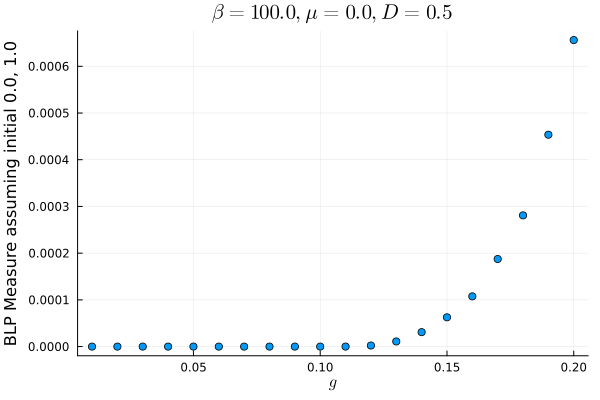

In [39]:
D = 0.5
beta = 100.0
mu = 0.0
N=100

gs = 0.01:0.01:0.2
BLP = []
for g in gs
    J = create_spectral("elliptical", D, g)
    J1, J2 = thermofield_transform(J, beta, mu)

    E1, h1 = chain_map(J1, N, D)
    E2, h2 = chain_map(J2, N, D)
    
    cut = 1 #findfirst(k -> maximum(h1[k:k+10]) - minimum(h1[k:k+10]) < 0.001 , collect(1:length(h1)-10))

    H = make_H_matrix(E1, E2, h1, h2, Esys, N, sys)
    C0_full = prepare_correlations(N,sys,1.0)
    C0_empty = prepare_correlations(N,sys,0.0)
    Cs_full = evolve_corrs(C0_full, H, dt, tmax, N)
    Cs_empty = evolve_corrs(C0_empty, H, dt, tmax, N)
    len = length(Cs_full)

    d2 = [trace_distance(Cs_full[t], Cs_empty[t], cut, N) for t in 1:len]
    Df = d2[2:end]
    Di = d2[1:end-1]
    dD_dt = real.(Df-Di)
    Nphi = sum(dD_dt[dD_dt .>= 0.0])
    push!(BLP, Nphi)
end

p = plot(gs, BLP, xlabel="\$ g \$", ylabel="BLP Measure assuming initial 0.0, 1.0",
    title="\$ \\beta=$(beta), \\mu=$(mu), D=$(D) \$",label="", seriestype=:scatter)

    


